In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from annoy import AnnoyIndex

import pickle
from multiprocessing import Pool

# for dimensionality reduction
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE, Isomap, MDS, SpectralEmbedding

# for clustering
from sklearn.cluster import *
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/schikanski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
seed_list = ['hair_dryer', 'video_codec', 'diesel', "contact_lens", "contact_lens_us_c", "3d_printer"]
src_dir = '.'
seeds = [seed_list[1]]
seed_name = seeds[0]

with open(src_dir + "/data/" + seed_name + "/ranked.pkl", 'rb') as infile:
    df = pickle.load(infile)

doc_embeddings = np.array(df['document_embeddings'].to_list()).squeeze()

In [5]:
selection = np.concatenate(df['sentence_embeddings'].to_list(), axis=0).squeeze()

In [6]:
# pca = KernelPCA(n_components=2, kernel='poly', degree=8, fit_inverse_transform=False)
# pca.fit(selection) # 40k samples, duration: 
# transformed = pca.transform(doc_embeddings)

# pca = KernelPCA(n_components=2, kernel='cosine') # ['linear', 'poly', 'rbf', 'sigmoid', 'cosine', 'precomputed']
# pca.fit(selection) # 40k samples, duration: 
# transformed = pca.transform(doc_embeddings)

# tsne = TSNE(2, perplexity=50, early_exaggeration=100, learning_rate=100)
tsne = TSNE(2)
transformed = tsne.fit_transform(doc_embeddings)

# iso = Isomap()
# iso.fit(selection) # 40k samples, duration: > 200s
# transformed = iso.transform(doc_embeddings)

# mds = MDS()
# transformed = mds.fit_transform(doc_embeddings)

# se = SpectralEmbedding()
# transformed = se.fit_transform(doc_embeddings)

# inverse_transformed = pca.inverse_transform(transformed)

# f = inverse_transformed.shape[1]
# t = AnnoyIndex(f, 'euclidean')
# for idx, val in enumerate(inverse_transformed):
#     t.add_item(idx, val.squeeze())

# t.build(10)

# result_inversed = t.get_nns_by_item(0, 500)
# result_inversed # doesn't work that well...

# fig = plt.figure(figsize=(30,20))
# sns.scatterplot(data=transformed)

In [8]:
# cluster = OPTICS(min_samples=5, metric='euclidean', min_cluster_size=0.001, xi=0.05, algorithm='auto').fit(transformed) # ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
# cluster = OPTICS().fit(transformed)
cluster = AffinityPropagation(max_iter=1000, random_state=0).fit(transformed)
# cluster = KMeans(20, random_state=0, init='random', n_init=1000, algorithm='auto', tol=1e6, max_iter=1000).fit(transformed)
# cluster = KMeans().fit(transformed)
# cluster = DBSCAN(eps=0.01, min_samples=2).fit(transformed)
# clutser = AgglomerativeClustering(n_clusters=10).fit(transformed)
# cluster = SpectralClustering(n_clusters=10).fit(transformed)

In [9]:
# CAK-means (thought of that by my self before finding a corresponding paper!)
cluster2 = KMeans(len(np.unique(cluster.labels_)), init=cluster.cluster_centers_).fit(transformed)

/home/schikanski/miniconda3/envs/pev2/lib/python3.9/site-packages/daal4py/sklearn/cluster/_k_means_0_23.py:306: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  _daal4py_k_means_fit(


In [10]:
np.unique(cluster.labels_ == cluster2.labels_, return_counts=True)

(array([False,  True]), array([  9, 191]))

<AxesSubplot:xlabel='x', ylabel='y'>

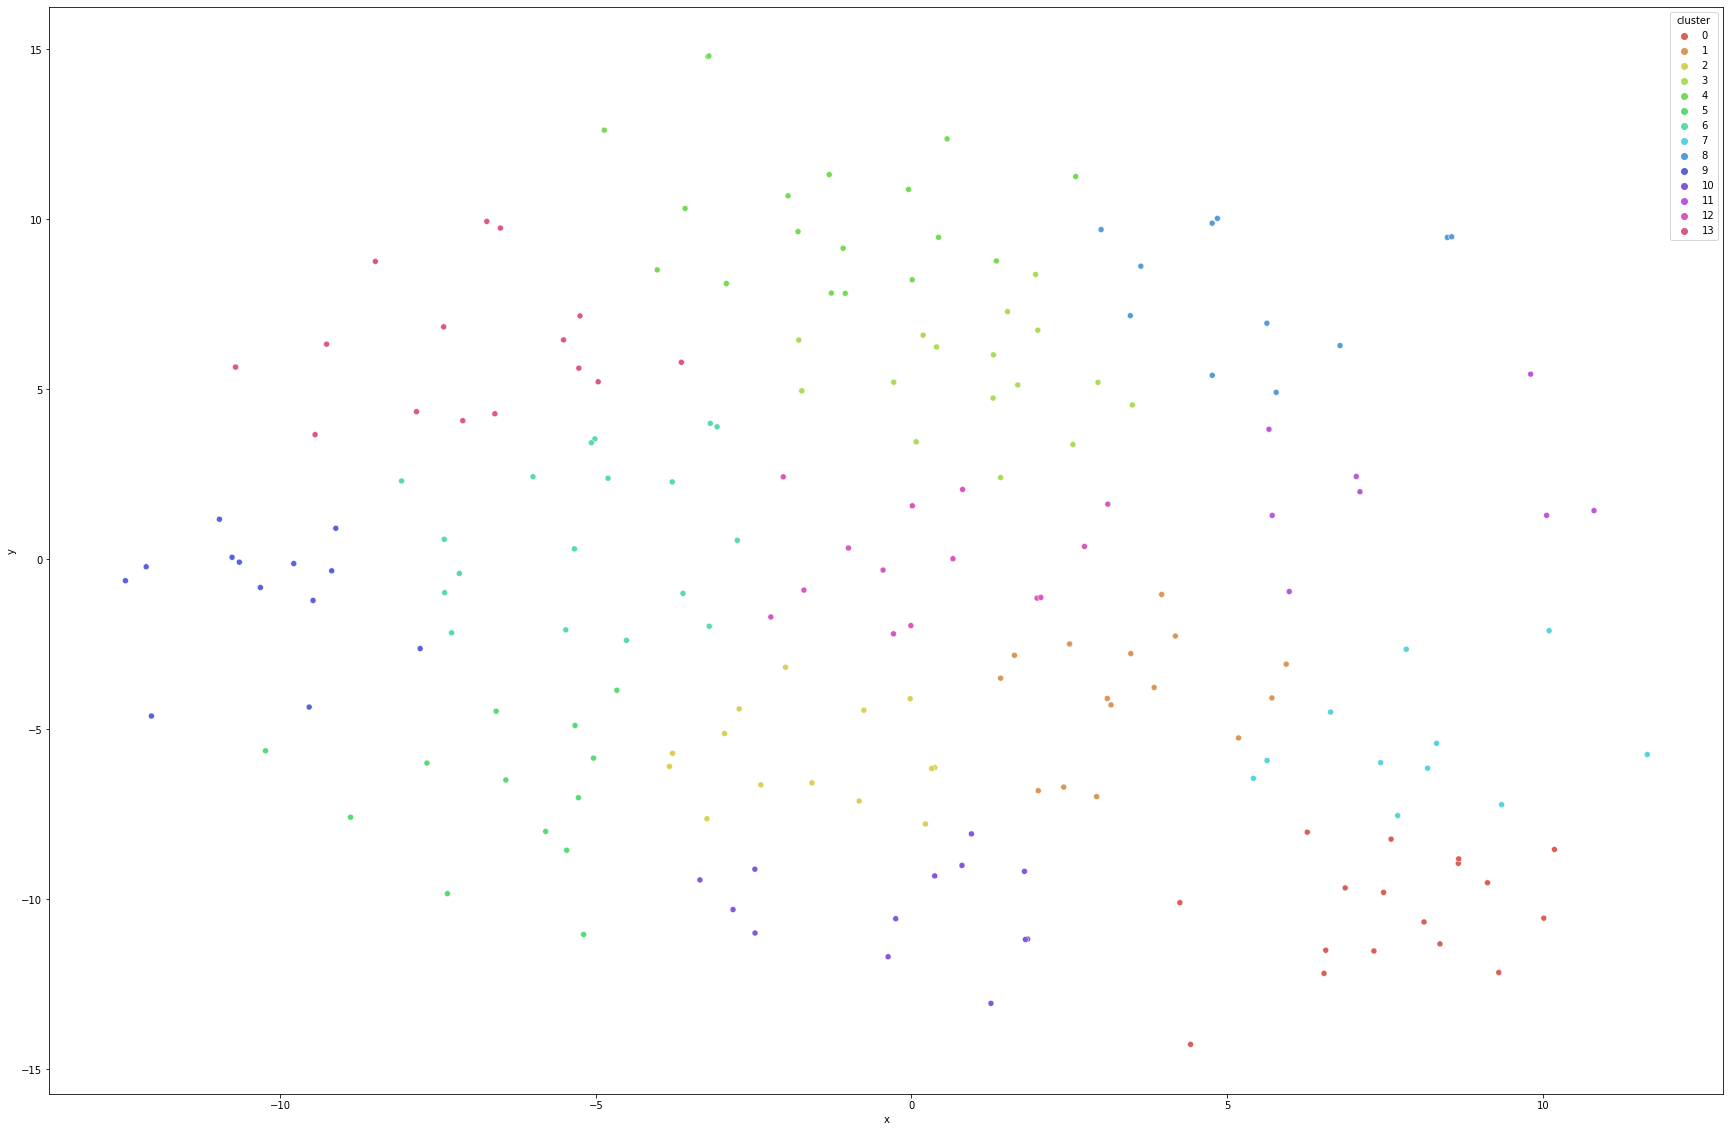

In [11]:
cluster_df = pd.DataFrame({'x': transformed.T[0], 'y': transformed.T[1], 'cluster':cluster.labels_})
fig = plt.figure(figsize=(30,20))
sns.scatterplot(data=cluster_df, x='x', y='y', hue='cluster', palette=sns.color_palette('hls', n_colors=np.unique(cluster.labels_).shape[0])) # hls, tab10, Paired
# sns.scatterplot(data=cluster_df[cluster_df['cluster'] == -1], x='x', y='y', palette=sns.color_palette('tab10', n_colors=np.unique(cluster.labels_).shape[0])) # hls, tab10, Paired

<AxesSubplot:xlabel='x', ylabel='y'>

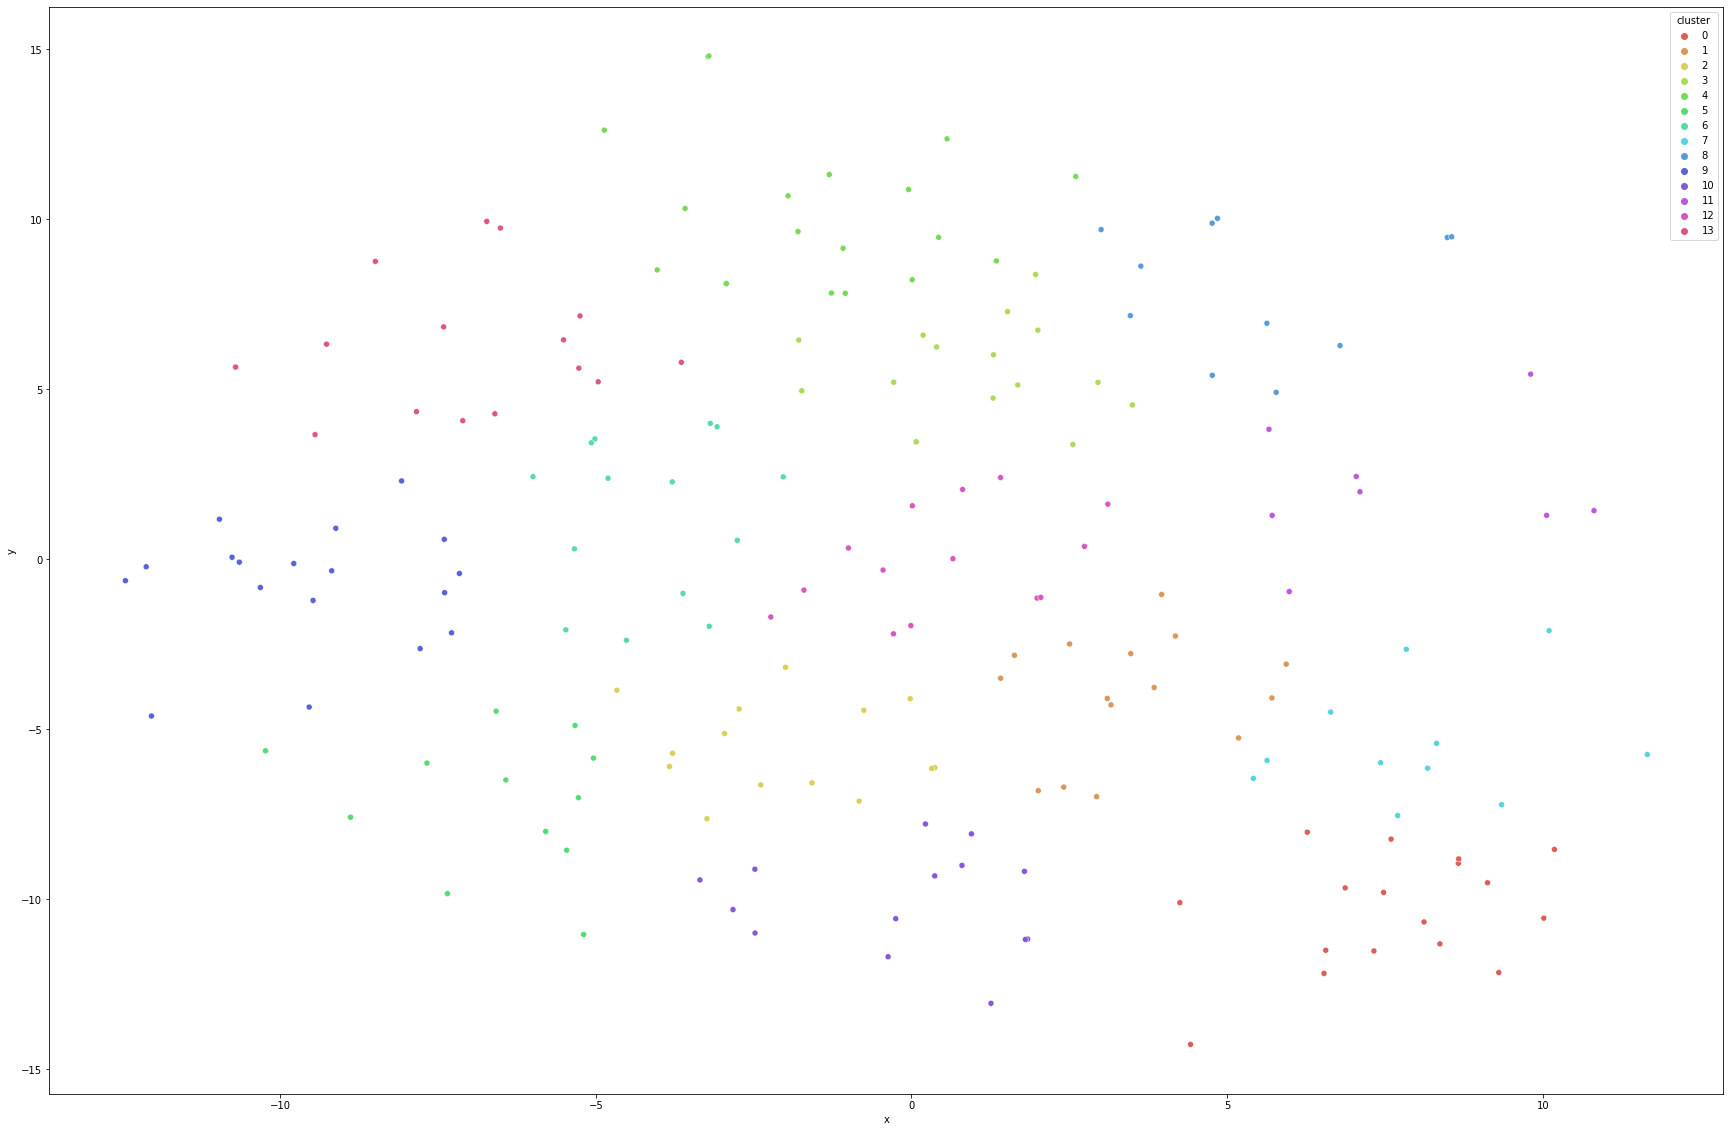

In [12]:
cluster_df2 = pd.DataFrame({'x': transformed.T[0], 'y': transformed.T[1], 'cluster':cluster2.labels_})
fig = plt.figure(figsize=(30,20))
sns.scatterplot(data=cluster_df2, x='x', y='y', hue='cluster', palette=sns.color_palette('hls', n_colors=np.unique(cluster.labels_).shape[0])) # hls, tab10, Paired
# sns.scatterplot(data=cluster_df[cluster_df['cluster'] == -1], x='x', y='y', palette=sns.color_palette('tab10', n_colors=np.unique(cluster.labels_).shape[0])) # hls, tab10, Paired

In [13]:
# two different clusters just for comparison. AP -> K-Means is going to be chosen.

cluster = cluster2
cluster_df = cluster_df2

In [14]:
new_df = df.copy()
new_df['orig_idx'] = new_df.index
new_df = new_df.reset_index()
new_df['cluster'] = cluster_df['cluster']
new_df['2D_coordinates'] = list(transformed)

with open(src_dir + "/data/" + seed_name + "/clustered.pkl", 'wb') as outfile:
    pickle.dump(new_df, outfile)